<a href="https://colab.research.google.com/github/saishdesai23/Stock-Price-Prediction/blob/main/Stock_Price_Prediction_And_Forecasting_Using_Stacked_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock prediction and forcasting using LSTM and Time Series Analysis
### Predicting the stock price for Google and Forcasting the stock price for Google for the next 100 days

# 1. Importing all the required libraries

In [ ]:
import pandas_datareader as pdr

In [ ]:
stock_data = pdr.get_data_tiingo('GOOGL', api_key='81e773aad74f1d152ac33fbc8920dd1307666da6')

/usr/local/lib/python3.7/dist-packages/pandas_datareader/tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return pd.concat(dfs, self._concat_axis)


In [ ]:
stock_data.to_csv("GOOGL.csv")

We have extracted the stock price data for Google from the time period 05/12/2017 to 05/10/2022

In [ ]:
stock_data.head()

close      high     low    open   volume  \
symbol date                                                                   
GOOGL  2017-05-12 00:00:00+00:00  955.14  957.9800  952.06  957.85  1204133   
       2017-05-15 00:00:00+00:00  959.22  962.7000  952.82  955.29  1314574   
       2017-05-16 00:00:00+00:00  964.61  965.8955  960.35  963.55  1069898   
       2017-05-17 00:00:00+00:00  942.17  960.9900  940.06  959.70  2414323   
       2017-05-18 00:00:00+00:00  950.50  954.1800  941.27  943.20  1758452   

                                  adjClose   adjHigh  adjLow  adjOpen  \
symbol date                                                             
GOOGL  2017-05-12 00:00:00+00:00    955.14  957.9800  952.06   957.85   
       2017-05-15 00:00:00+00:00    959.22  962.7000  952.82   955.29   
       2017-05-16 00:00:00+00:00    964.61  965.8955  960.35   963.55   
       2017-05-17 00:00:00+00:00    942.17  960.9900  940.06   959.70   
       2017-05-18 00:00:00+00:00    950.50  954.1800  941.27   943.20   

                                  adjVolume  divCash  splitFactor  
symbol date                                                        
GOOGL  2017-05-12 00:00:00+00:00    1204133      0.0          1.0  
       2017-05-15 00:00:00+00:00    1314574      0.0          1.0  
       2017-05-16 00:00:00+00:00    1069898      0.0          1.0  
       2017-05-17 00:00:00+00:00    2414323      0.0          1.0  
       2017-05-18 00:00:00+00:00    1758452      0.0          1.0

In [ ]:
stock_data.tail()

close       high        low     open  \
symbol date                                                                
GOOGL  2022-05-04 00:00:00+00:00  2445.22  2457.0900  2302.3200  2340.63   
       2022-05-05 00:00:00+00:00  2330.11  2420.7800  2300.1150  2404.08   
       2022-05-06 00:00:00+00:00  2314.93  2351.4300  2280.3100  2303.69   
       2022-05-09 00:00:00+00:00  2250.22  2301.5418  2240.0101  2265.00   
       2022-05-10 00:00:00+00:00  2287.90  2325.0000  2258.0100  2310.15   

                                   volume  adjClose    adjHigh     adjLow  \
symbol date                                                                 
GOOGL  2022-05-04 00:00:00+00:00  2487859   2445.22  2457.0900  2302.3200   
       2022-05-05 00:00:00+00:00  2292029   2330.11  2420.7800  2300.1150   
       2022-05-06 00:00:00+00:00  1985479   2314.93  2351.4300  2280.3100   
       2022-05-09 00:00:00+00:00  2040143   2250.22  2301.5418  2240.0101   
       2022-05-10 00:00:00+00:00  1995019   2287.90  2325.0000  2258.0100   

                                  adjOpen  adjVolume  divCash  splitFactor  
symbol date                                                                 
GOOGL  2022-05-04 00:00:00+00:00  2340.63    2487859      0.0          1.0  
       2022-05-05 00:00:00+00:00  2404.08    2292029      0.0          1.0  
       2022-05-06 00:00:00+00:00  2303.69    1985479      0.0          1.0  
       2022-05-09 00:00:00+00:00  2265.00    2040143      0.0          1.0  
       2022-05-10 00:00:00+00:00  2310.15    1995019      0.0          1.0

In [ ]:
import pandas as pd

In [ ]:
google_stock_data = pd.read_csv("GOOGL.csv")

Let us focus on the closing value of the stock price for each observation.

In [ ]:
google_close_data = google_stock_data.reset_index()['close']

In [ ]:
# size of the dataframe
google_close_data.shape

(1258,)

Let us plot the dataframe to visualize the variation in the stock price for the selected time frame

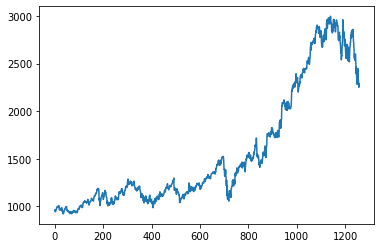

In [ ]:
import matplotlib.pyplot as plt
plt.plot(google_close_data)

In [ ]:
import numpy as np

### 1. Standardizing the data using Min Max Scaler
We will first standardize the data using min-max scalar so that it can be used by an LSTM model for training

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
google_close_data=scaler.fit_transform(np.array(google_close_data).reshape(-1,1))
google_close_data

array([[0.01717606],
       [0.01914014],
       [0.02173484],
       ...,
       [0.67176782],
       [0.64061695],
       [0.65875579]])

In [ ]:
google_close_data.shape

(1258, 1)

###2. Train test split
For performing train test split on time series data, we will choose a date such that 70% observations before it will be in the train data set and the remaining 30% observations following it will be in the test data set

In [ ]:
# train test split
train_size = int(len(google_close_data)*0.70)
test_size = len(google_close_data) - train_size
train_data, test_data = google_close_data[0:train_size,:], google_close_data[train_size:len(google_close_data),:1]

In [ ]:
print(len(train_data), len(test_data))

880 378


###3. Generation of a Datast matrix
Based on the time step selected, the number of values selected in the time step will form the features for each observation and the succeeding value will be treated as an outcome

In [ ]:
def create_dataset(dataset, time_step=1):
  """
  A function to convert an array of values into a dataset matrix
  """
  X, y = [], []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step),0]
    X.append(a)
    Y.append(dataset[i+time_step, 0])
  return numpy.array(X), numpy.array(Y)

In [ ]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
X_train.shape

(716, 100)

In [ ]:
y_train.shape

(716,)

In [ ]:
X_test.shape

(340, 100)

In [ ]:
y_test.shape

(340,)

In [ ]:
#reshape the input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1 )
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1 )

In [ ]:
# create LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
12/12 [==============================] - 18s 610ms/step - loss: 0.0442 - val_loss: 0.0117
Epoch 2/100
12/12 [==============================] - 4s 366ms/step - loss: 0.0084 - val_loss: 0.0101
Epoch 3/100
12/12 [==============================] - 4s 361ms/step - loss: 0.0038 - val_loss: 0.0013
Epoch 4/100
12/12 [==============================] - 4s 362ms/step - loss: 0.0014 - val_loss: 3.6117e-04
Epoch 5/100
12/12 [==============================] - 5s 380ms/step - loss: 0.0013 - val_loss: 2.9202e-04
Epoch 6/100
12/12 [==============================] - 4s 368ms/step - loss: 0.0012 - val_loss: 3.4475e-04
Epoch 7/100
12/12 [==============================] - 4s 369ms/step - loss: 0.0012 - val_loss: 4.3751e-04
Epoch 8/100
12/12 [==============================] - 5s 380ms/step - loss: 0.0011 - val_loss: 3.1174e-04
Epoch 9/100
12/12 [==============================] - 4s 377ms/step - loss: 9.8277e-04 - val_loss: 4.3518e-04
Epoch 10/100
12/12 [==============================] - 4s 359ms

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [ ]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [ ]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predict))

225.24635795439588

In [ ]:
math.sqrt(mean_squared_error(y_test, test_predict))

149.4291404905064